In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
from matplotlib.patches import Circle

from xenodiffusionscope import Source
from xenodiffusionscope import TPC
from xenodiffusionscope import ElectronDrift 
from xenodiffusionscope import MeshGrid

from hexalattice.hexalattice import create_hex_grid

import plot_utils as pu
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Figure size and DPI
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['figure.dpi'] = 100

# Font family and size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Utopia']
plt.rcParams['font.size'] = 50

# Mathtext font set
plt.rcParams['mathtext.fontset'] = 'cm'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TPC and initial electrons

In [3]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)

In [4]:
import csv
import numpy as np

def read_positions_from_file(file_name):
    positions = []
    with open(file_name, 'r') as file:
        reader = csv.reader(file)
        next(reader) 
        for row in reader:
            x_pos, y_pos, z_pos, _ = map(float, row)
            positions.append([x_pos, y_pos, z_pos])
    return positions

In [5]:
# Load data
file_name = "../data/Ba133_170_1.csv" 

positions = read_positions_from_file(file_name)

# Convert positions to array
positions = np.array(positions)

In [14]:
print(positions)

[[-3.94159544e+00  4.57785693e+00  2.60085449e+03]
 [-3.59428645e+00 -3.15513202e+00  2.60085449e+03]
 [ 3.26564854e+00  7.16199813e+00  2.60085449e+03]
 [ 3.03452412e+00  7.82707456e+00  2.60085449e+03]
 [ 1.11844702e+00 -6.87247276e-02  2.60085449e+03]
 [ 4.08383403e-02  1.67811477e+00  2.60085449e+03]
 [ 1.78484217e+00  2.54129814e+00  2.60085449e+03]
 [-3.77434609e+00 -1.51337354e+00  2.60085449e+03]
 [-2.63476571e+00  7.18373637e+00  2.60085449e+03]
 [ 3.72646827e-01 -2.18108181e+00  2.60085449e+03]
 [ 8.35719670e-01  1.10756130e+00  2.60085449e+03]
 [ 2.39731011e-01 -8.60317921e+00  2.60085449e+03]
 [ 5.88974386e+00  1.76140996e+00  2.60085449e+03]
 [-1.79925010e+00  2.84240719e+00  2.60085449e+03]
 [-2.20552774e+00 -1.91190772e+00  2.60085449e+03]
 [ 2.94258731e+00 -5.28934650e+00  2.60085449e+03]
 [ 2.65159899e+00  1.07602017e+01  2.60085449e+03]
 [-4.68309041e-02 -1.78136241e+00  2.60085449e+03]
 [-1.19835099e+00  4.15263332e+00  2.60085449e+03]
 [-9.06637975e-01 -5.56042733e+

## Drift and diffuse

In [7]:
# Initialise a drift simulator
drift = ElectronDrift(positions, Xenoscope)

# Drift the electrons to the gate and get the final positions
x, y , z = drift.drift_electrons()

#Apply e-lifetime and extraction efficiency, electrons are suppressed 
#x_corr_elifetime,y_corr_elifetime,z_corr_elifetime = drift.apply_elifetime(x,y,z)
x_extracted,y_extracted, z_extracted = drift.apply_corrections(x,y,z)

In [13]:
# print(x_extracted)

[-3.94159544 -3.59428645  3.26564854 -2.63476571 -2.20552774 -1.19835099
 -0.90663798 -0.8909519  -0.12056451  3.55512175 -8.54967712 -1.85105467
 -1.2326538  -5.13900543 -1.1927696   1.19668145 -3.11188873 -0.46556477
  2.33239374  3.58432033  5.37931943 -0.55583539  0.53378711  0.14720902
  2.31011475 -4.27109681  2.55234634  5.42856243 -0.35856032  0.47472768
  2.09552964 -0.57908748 -2.08427484  0.39361293  2.01699094  3.37920342
 -5.55055959 -2.52936413 -3.35223721 -3.2720536   4.89013126 -0.55457851
  2.08518363 -2.68480104 -0.68052848  0.19521353  3.80164701 -5.19341319
 -1.13195072 -1.7538509   3.10609027 -3.41684342  0.0961969   2.71994877
 -3.21800127 -6.71033162 -0.13990327  0.60661231  2.76644602  5.99394205
 -5.26627669  2.57184872  1.80039301 -0.92005816  2.20923158]


## Focus on mesh grid

In [9]:
# Create a mesh object 
mesh = Xenoscope.gate_mesh

#Focus electrons on hex centers
e_pos = np.stack((x_extracted, y_extracted, z_extracted), axis = 1)

pos_focus = mesh.focus_on_grid(e_pos)

pos_counts = mesh.count_focused(pos_focus)

counts_pe_on_hex = drift.convert_electron_to_photons(pos_counts)

Counting hits in hex centers: 100%|██████████| 2787/2787 [00:00<00:00, 118925.31it/s]


In [10]:
# how many hexagon we need?
r_max = 75
a = 1.56
r_hex = a * np.sqrt(3)

n_hex_x = 2 * np.ceil(75/r_hex)
n_hex_y = 2 * np.ceil(75/(3/2*a))

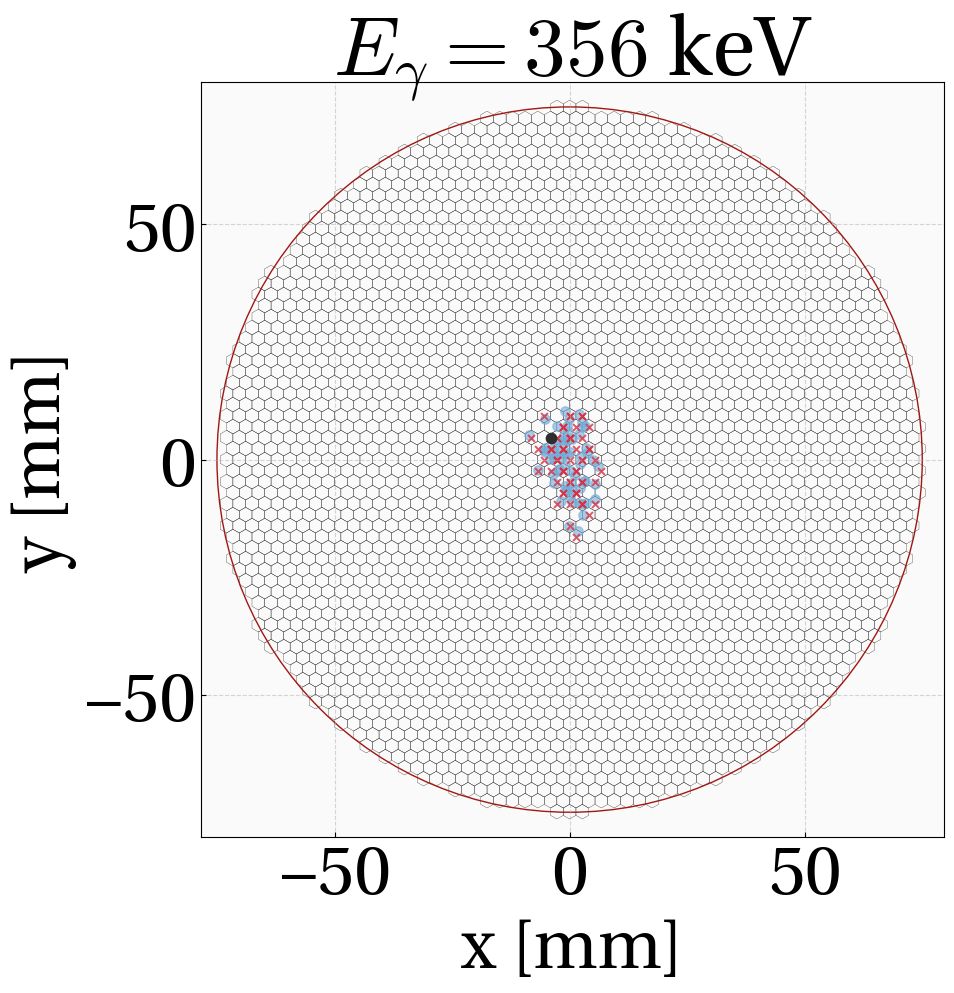

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

hex_centers, _ = create_hex_grid(nx=n_hex_x, ny=n_hex_y, min_diam=r_hex, crop_circ=r_max, h_ax=ax, do_plot=True)

# Initial positions of point sources 
x0 = -3.94159544e+00
y0 = 4.57785693e+00 


# Final positions on gate
ax.scatter(e_pos[:1000, 0], e_pos[:1000, 1], label='Unfocused', alpha=0.6, s=45, c = '#72ACD9')
ax.scatter(pos_focus[:1000, 0], pos_focus[:1000, 1], label='Focused', marker='x', linewidth=1.4, alpha=0.8, s=25, c = '#D92F41')

ax.scatter(x0, y0, color='#2E2E2E', label= 'Initial', marker='o', s=55)
# TPC radius 
c = Circle((0,0), r_max, fill = False, color = '#A01813')
ax.add_patch(c)

# Set axis labels
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

# Set legend
# ax.legend(loc='upper right', fontsize = 'small')

# Set title
ax.set_title('$E_{\gamma} = 356$ keV')

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Set background color
ax.set_facecolor('#FAFAFA')
        
save_path = "/home/atp/souaha/souahada/figures/XenoDiffusion/Ba133_356_C.png"
plt.savefig(save_path, facecolor="white", bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()